In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

C:\Users\eltor\AppData\Local\Temp\ipykernel_14416\3290819143.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='max', interval='1d')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,RSI,RSI_Strategy,BB_SMA,BB_STD,Upper_Band,Lower_Band,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,,,,,,,,
1993-02-25,24.537848,24.555140,24.416801,24.468678,44500,43.182083,0.0,24.314768,0.302872,24.617640,24.011896,NaN,NaN,0.0,NaN,NaN
1993-02-26,24.572420,24.589712,24.451374,24.589712,66200,39.758958,0.0,24.285371,0.253649,24.539021,24.031722,0.0,0.0,0.0,0.001409,0.000000
1993-03-01,24.503262,24.658893,24.468677,24.658893,66500,43.420946,0.0,24.268079,0.228714,24.496793,24.039364,-1.0,-1.0,0.0,-0.001409,0.000000
1993-03-02,24.866388,24.866388,24.485957,24.520541,182400,88.525509,0.0,24.349352,0.282201,24.631553,24.067151,-1.0,-1.0,0.0,0.013389,0.000000
1993-03-03,24.970146,24.987439,24.866392,24.900977,280100,90.910322,-1.0,24.442731,0.319194,24.761924,24.123537,-1.0,-2.0,-1.5,0.017618,-0.006259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-10,653.020020,673.950012,652.840027,672.130005,159422600,37.905400,-1.0,667.475995,5.746184,673.222179,661.729811,0.0,-1.0,0.0,25.612767,25.363209
2025-10-13,663.039978,665.130005,659.770020,660.650024,79560500,49.281525,0.0,667.411993,5.796506,673.208499,661.615488,1.0,1.0,0.0,26.021114,25.363209
2025-10-14,662.229980,665.830017,653.169983,657.169983,88779600,45.390862,0.0,667.016992,6.020063,673.037056,660.996929,0.0,0.0,0.0,25.988104,25.363209


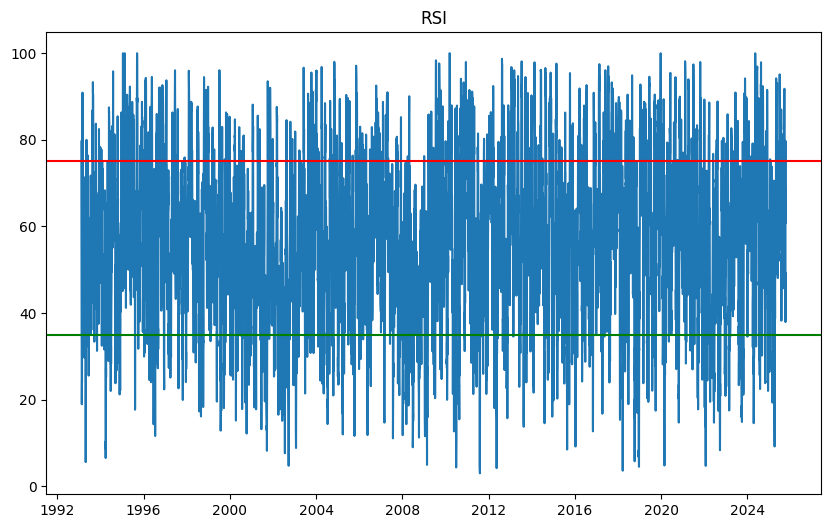

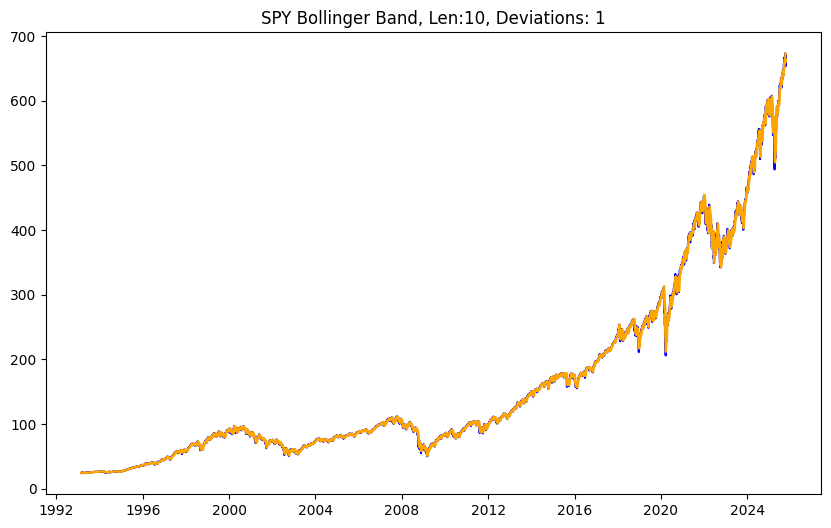

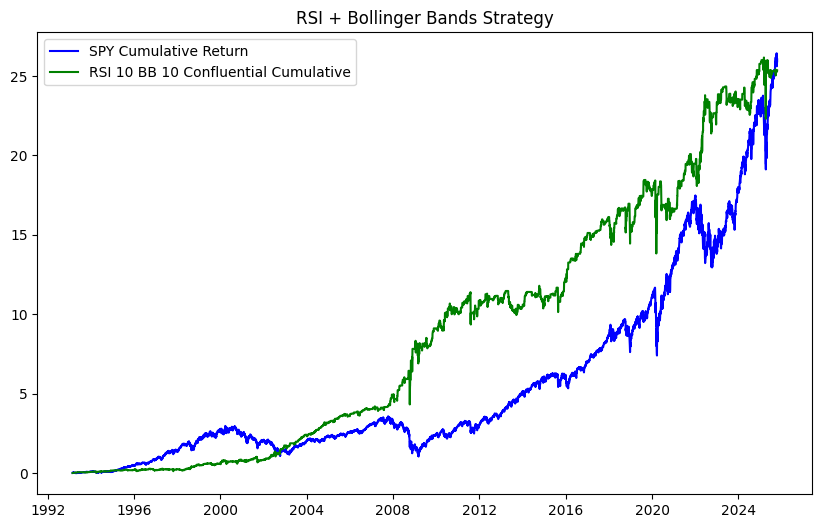

In [15]:
TICKER = 'SPY'
INTERVAL = '5m'
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max' 

RSI_LENGTH = 10
OVERBOUGHT = 75
OVERSOLD = 35
LOOKBACK = 10000
BB_LEN = 10
DEVS = 1

def get_data(ticker=TICKER):
    df = yf.download(ticker, period='max', interval='1d')
    df.columns = df.columns.get_level_values(0)
    
    return df.iloc[-LOOKBACK:, :]

def add_RSI(df, length=RSI_LENGTH):

    price_change = df['Close'].diff()
   
    # separate gain/loss
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss gain.rolling(window=length).mean() loss.rolling(window=length).mean()
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.figure(figsize=(10,6))
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')
    plt.title('RSI')

    return df.dropna()


def add_RSI_strategy(df, overbought = OVERBOUGHT, oversold = OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, np.where(df['RSI'] < oversold, 1, 0) )
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)

    return df

def add_BB(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (using macd code/ewm)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()
    # get sd of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] =df['BB_SMA'] - (devs * df['BB_STD'])

    df = df.dropna()

    # Graph
    plt.figure(figsize=(10,6))
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color = 'orange')
    plt.plot(df['Lower_Band'], color = 'orange')
    plt.title(f'{TICKER} Bollinger Band, Len:{BB_LEN}, Deviations: {DEVS}')
    return df

def add_BB_strategy(df):
    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(df['Close'] > df['Upper_Band'], -1, np.where(df['Close'] < df['Lower_Band'], 1, 0) )
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)

    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['BB_Strategy'] + df['RSI_Strategy']
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1.5, np.where(df['Full_Strategy'] == -2, -1.5, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1

    plt.figure(figsize=(10,6))
    plt.plot(df['Asset_Returns'], color='blue')
    plt.plot(df['Strategy_Returns'], color='green')
    plt.legend([f'{TICKER} Cumulative Return', f'RSI {RSI_LENGTH} BB {BB_LEN} Confluential Cumulative'])
    plt.title('RSI + Bollinger Bands Strategy')

    return df



def main():
    df = get_data()
    df = add_RSI(df)
    df = add_RSI_strategy(df)
    df = add_BB(df)
    df = add_BB_strategy(df)
    df =add_full_strategy(df)
    df =test_strategy(df)

    return df

df = main()

df